В данном задании необходимо обучить алгоритм REINFORCE на любой среде из библиотеки gym, кроме Pong.

Документацию по средам gym можно найти по следующей ссылке: https://gym.openai.com/envs/

Мною выбрана среда Breakout. Посмотрим, что из этого вышло...
______________________________________________________________________

Скачиваем нужные файлы для библиотеки gym.

Обратите внимание, что этот этап нужен лишь для некоторых сред из библиотеки.

In [1]:
! wget http://www.atarimania.com/roms/Roms.rar
! mkdir /content/ROM/
! unrar e /content/Roms.rar /content/ROM/
! python -m atari_py.import_roms /content/ROM/

--2022-03-30 07:36:54--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11128004 (11M) [application/x-rar-compressed]
Saving to: ‘Roms.rar’

Roms.rar            100%[===================>]  10.61M   262KB/s    in 44s     

2022-03-30 07:37:39 (249 KB/s) - ‘Roms.rar’ saved [11128004/11128004]


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/Roms.rar

Extracting  /content/ROM/HC ROMS.zip                                      36%  OK 
Extracting  /content/ROM/ROMS.zip                                         74% 99%  OK 
All OK
copying adventure.bin from ROMS/Adventure (1980) (Atari, Warren Robinett) (CX2613, CX2613P) (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin fr

Импортируем все нужные модули и библиотеки.

In [2]:
import gym         #Импортируем библиотеку gym (встроенная в колаб)
import numpy as np #Импортируем numpy
from tensorflow.keras.models import Model, load_model #Импортируем функцию для создания модели и загрузки модели
from tensorflow.keras.layers import * #Импортируем все слои кераса
from tensorflow.keras.optimizers import RMSprop #Импортируем оптимизатор RMSprop
import tensorflow as tf                    #Импортируем тензорфлоу
import matplotlib.pyplot as plt            #Импортируем pyplot для визуализации данных
import pickle                              #Импортируем модуль pickle для сохранения и загрузки данных
from moviepy.editor import *               #Импортируем полезные функции из библиотеки для возпроизведение видео с результатом
import cv2                                 #Импортируем библиотеку cv2 (используется для воспроизведение видео)
from google.colab import output            #Импортируем функцию для управления вывода в колаб-ячейках

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2236416/45929032 bytes (4.9%)5791744/45929032 bytes (12.6%)9404416/45929032 bytes (20.5%)12967936/45929032 bytes (28.2%)16564224/45929032 bytes (36.1%)20291584/45929032 bytes (44.2%)23691264/45929032 bytes (51.6%)27385856/45929032 bytes (59.6%)30859264/45929032 bytes (67.2%)34496512/45929032 bytes (75.1%)37937152/45929032 bytes (82.6%)41558016/45929032 bytes (90.5%)

In [3]:
env = gym.make('Breakout-v0')          #Создаем игровую среду через библиотеку gym

In [4]:
state = env.reset()                #Начинаем новый эпизод, извлекаем состояние
print("Пример состояния:", state)  #Отображаем пример состояние (будет скалярное число)
print("Пространство действий:", env.action_space) #Смотрим на размер пространства действий

Пример состояния: [[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
Пространство действий: Discrete(4)


In [5]:
# Запускаем среду (это действие возвращает начальное состояние)
new_frame = env.reset()        

# Взглянем на размерность состояния
print(f"Размерность состояния: {new_frame.shape}") 

Размерность состояния: (210, 160, 3)


In [6]:
# Взглянем на все возможные действия и узнаем, что они делают 
env.unwrapped.get_action_meanings() 

['NOOP', 'FIRE', 'RIGHT', 'LEFT']

Итак, мы запустили новую среду, Breakout-v0. Ее состояние - каринка размерностью 210, 160, 3. В данной среде у агента есть возможность совершить 4 дискретные действия:

Noop — ничего не делать.
Fire — запустить мяч.
Right — двигать вправо.
Left — двигать влево.

Cоздадим список из действий, которые можно использовать.

In [7]:
# Создаем массив возможных действий. Агент может стоять на месте, двигаться влево или вправо
action_space = [0, 1, 2, 3] 

In [8]:
# Записываем в переменную количество уникальных возможных действий — также известно как размерность пространства действий
num_actions = len(action_space) 

Используем pyplot, чтобы посмотреть на различные кадры, которые мы получаем из среды. Подадим 20 рандомных действий в среду и взглянем на каждый кадр, который получается после каждого действия. Это поможет нам понять, как выглядит игровой процесс.

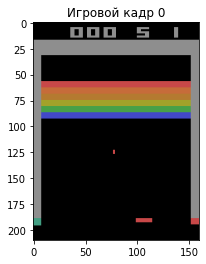

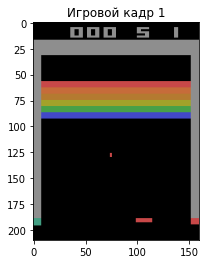

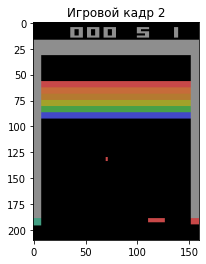

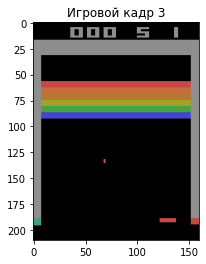

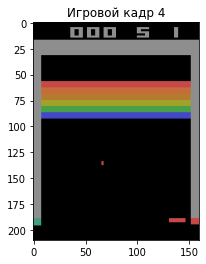

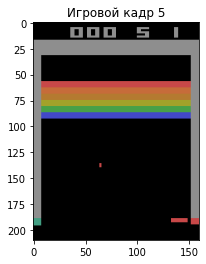

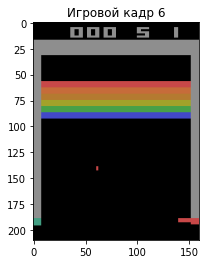

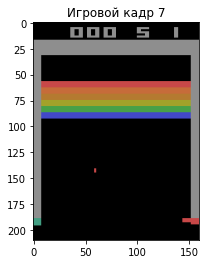

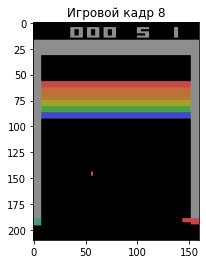

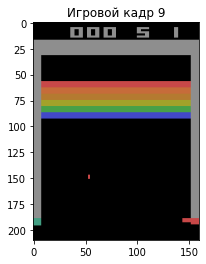

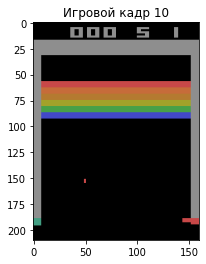

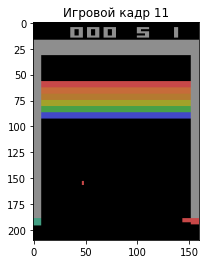

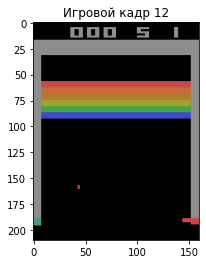

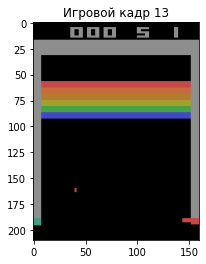

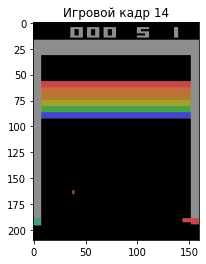

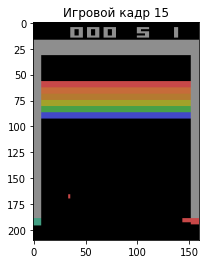

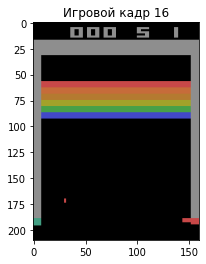

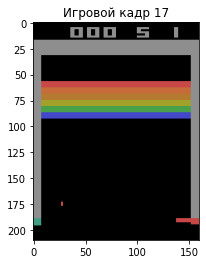

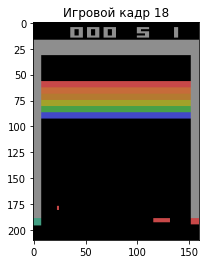

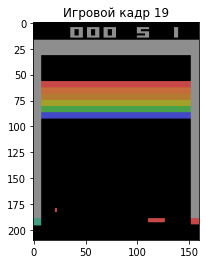

In [9]:
# Начинаем новую игру
env.reset()         

# Запускаем цикл 5 раз
for i in range(20): 

  # Подаем рандомное действие на вход. На выходе получаем новую информацию о текущем состоянии игры
  new_frame, reward, done, misc = env.step(np.random.choice(action_space)) 
  
  # Рисуем изображения
  plt.imshow(new_frame)  
  
  # Добавляем заголовок                         
  plt.title(f"Игровой кадр {i}", fontsize = 12)  
  
  # Показываем изображения 
  plt.show()      

In [11]:
# Создадим функцию для предобработки кадра — превращает цвет в черно-белый, отсекает ненужные части кадра и сжимает.
def preprocess_frame(frame):      

  ''' Функция предобработки кадра. 
      Превращает цвет в черно-белый, отсекает ненужные части кадра и сжимает.

      Аргументы: 
      frame - кадр
      
  '''

  # Меняем тип данных на float32
  frame = frame.astype(np.float32) 
  
  # Отсекаем ненужные части кадра, которые не принадлежат игровому полю
  frame = frame[35:195]           

  # Сжимаем изображение (берем каждый второй пиксель) 
  frame = frame[::2, ::2, 0]       
  
  # Удаляем фон (меняем на черный цвет — значение пикселя = 0)
  frame[frame == 144] = 0    

  # Удаляем фон (меняем на черный цвет — значение пикселя = 0)      
  frame[frame == 109] = 0    

  # Всё, что не принадлежит фону, меняем на белый цвет (значение пикселя = 1)  
  frame[frame != 0] = 1            
  
  return frame.reshape(80, 80, 1)  # Меняем форму итогового кадра на (80, 80, 1)

In [12]:
a=preprocess_frame(new_frame)

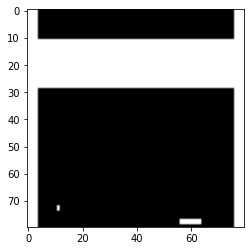

In [13]:
 # Рисуем изображения
plt.imshow(a[:,:,0], cmap='gray')
plt.show()

In [14]:
# Создадим функцию для склеивания двух кадров. Этот процесс даст нам текущее состояние, которое будет подаваться на вход нейронной сети.
def stack_frames(new_frame, 
                 old_frame):                  
                 
  ''' Функция склеивания кадров 
      Превращает цвет в черно-белый, отсекает ненужные части кадра и сжимает.

      Аргументы: 
      new_frame — новый кадр
      old_frame — старый кадр
      
  '''

  # Предобрабатываем новое изображение (используем выше объявленную функцию)
  new_frame = preprocess_frame(new_frame)  
  
  # Предобрабатываем старое изображение (используем выше объявленную функцию)                
  old_frame = preprocess_frame(old_frame)                  
  
  return np.concatenate([new_frame, old_frame], axis = -1) # Склеиваем изображения по 3-й (канальной) оси, и возвращаем.

## Создание нейронной сети

Сеть принимает на вход состояние с размерностью (80, 80, 2). На выходе будет слой с тремя нейронами, т. к. у нас три возможных действия, в которых будет содержаться вероятность принятия каждого действия.

In [15]:
def create_model():                     

  ''' Функция создания модели '''

  input = Input((80, 80, 2))             # Задаем входную размерность — (80, 80, 2)
  
  x = Flatten()(input)                   # Применяем выравнивающий слой
  x = Dense(1024, activation = 'elu')(x) # Полносвязный слой — эмпирическим методом выявлено, что с активационной функцией 'elu' сеть лучше обучается
  x = Dense(512, activation = 'elu')(x)  # Полносвязный слой — эмпирическим методом выявлено, что с активационной функцией 'elu' сеть лучше обучается
  
  output = Dense(num_actions, 
                 activation = 'softmax')(x) # Выходной слой, где считается вероятность совершения нужного действия

  # Создаем модель
  model = Model(input, output)   

  # Компилируем модель — используем оптимизатор RMSprop с низким шагом обучения
  model.compile(optimizer = RMSprop(learning_rate = 1e-4), loss = 'sparse_categorical_crossentropy') 

  return model   

In [16]:
# Нейронная сеть выдает вероятности принятия каждого действия. Ниже созданная функция использует эти вероятности для выбора конкретного действия.
def choose_action(state):     

  ''' Функция выбора действия 

      Аргументы: 
      state — состояние

  '''

  # Делаем предсказание
  probs = model.predict(state.reshape(1, 80, 80, 2))   
  
  # Выбираем индекс действия рандомно, используя предсказанные вероятности модели
  action_index = np.random.choice(num_actions, p = probs.flatten()) 
  
  # Возвращаем индекс рандомно выбранного действия (в игровом цикле мы будем обращаться к самому действию через этот индекс)
  return action_index     

In [17]:
# В данной среде у нас скудные награды, но мы должны предобработать их, чтобы какая-то награда назначалась за каждое действие.
def preprocess_rewards(rewards_list):

  ''' Функция предобработки наград. 

      Аргументы: 
      rewards_list - состояние

  '''
  # Инициализируем массив обработанных наград нулями
  discounted_rewards = np.zeros_like(rewards_list)  

  # running_add содержит предобработанную награду, которая назначается за действие — инициализируется нулем    
  running_add = 0                                       
  
  # Итерируем через массив наград в обратном порядке
  for i in reversed(range(len(discounted_rewards))):    
    
    # Если на заданный момент есть ненулевая награда, которая была назначена средой 
    if rewards_list[i] != 0:                            
      # переменная running_add обнуляется
      running_add = 0                                   
    
    # Задаем награду за текущее действие (псевдо-уравнение Беллмана)
    running_add = gamma * running_add + rewards_list[i] 

    # Записываем награду в массив обработанных наград
    discounted_rewards[i] = running_add                 
  
  # Возвращаем массив обработанных наград
  return discounted_rewards                  

In [18]:
def show_scores(scores, 
                episode_durations):

  ''' Функция отображения наград за эпизод. 

      Аргументы: 
      scores -  
      episode_durations - 

  '''    

  # Удаляем предыдущий вывод ячейки
  output.clear() 

  # Устанавливаем большой размер полотна
  fig, axes = plt.subplots(1, 2, figsize = (20, 8))    

  # Отрисовываем награды                        
  axes[0].plot(scores, linestyle = '--', label = 'Награда за эпизод')  

  # Считаем и отрисовываем скользящее среднее от награды        
  axes[0].plot(moving_average(scores), label = 'Скользящее среднее награды') 

  # Добавляем лейблы осей  
  axes[0].set_xlabel('Эпизод', fontsize = 12)                                  
  axes[0].set_ylabel('Награда', fontsize = 12)

  # Создаем легенду
  axes[0].legend()         
  
  # Отрисовываем длину эпизодов
  axes[1].plot(episode_durations, 'r', linestyle = '--', label = 'Длина эпизода (количество действий)')  
  
  # Считаем и отрисовываем скользящее среднее по длины эпизода
  axes[1].plot(moving_average(episode_durations), 'k', label = 'Длина эпизода (Скользящее среднее)')    
  
  # Добавляем лейблы осей
  axes[1].set_xlabel('Эпизод', fontsize = 12)                                                            
  axes[1].set_ylabel('Количество действий', fontsize = 12)
  
  # Создаем легенду
  axes[1].legend()         
  
  # Выводим график
  plt.show()

In [19]:
def moving_average(data, 
                   width = 20): 

  ''' Функция подсчета скользящего среднего всех значений
      
      Аргументы:
      data — входной массив,
      width — длина, на которую считаем скользящее среднее
  '''

  # Длина свертки (минимум из заданной длины свертки и длины датасета)
  width = min(width, len(data))  

  # Вместо паддинга из нулей мы создадим паддинг для свертки из первого значения массива. Весь паддинг будет слева (в начале массива)    
  data = np.concatenate([np.repeat(data[0], width), data])  
   
  # Возвращаем результат свертки данных на фильтр из единиц — наше скользящее среднее
  return (np.convolve(data, np.ones(width), 'valid') / width)[1:]  

In [20]:
# Создаем модель, используя ранее объявленную функцию
model = create_model() 

def train_model(episode_states, 
                episode_actions, 
                episode_rewards):
    
  ''' Функция для обучения модели 
  
      Аргументы:
      episode_states - 
      episode_actions - 
      episode_rewards -
  
  ''' 

  # Предобрабатываем награды, используя ранее объявленную функцию  
  rewards = preprocess_rewards(episode_rewards)  
  
  # Обучаем алгоритм на собранном пакете данных — одном полном эпизоде
  model.train_on_batch(episode_states, episode_actions, sample_weight = rewards) 

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 80, 2)]       0         
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 1024)              13108224  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 13,635,076
Trainable params: 13,635,076
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Гиперпараметр гамма 
gamma = 0.98 

In [23]:
# Если переменная load_pretrained равна True, мы загружаем веса обученной модели и историю наград, и продолжаем обучение. Если она равна False, мы начинаем обучение с нуля.
load_pretrained = False

In [24]:
# Если load_pretrained равна True:
if load_pretrained:  

  # Открываем файл, используя функцию из pickle
  with open('/content/scores.txt', 'rb') as f: 
    
    # Загружаем из файла ранее сохраненные данные (очки за эпизоды, длины эпизодов и номер эпизода)
    all_scores, all_episode_durations, episode_number = pickle.load(f)   
  
  # Загружаем сохраненные веса
  model.load_weights('/content/REINFORCE.h5')  

# Иначе 
else:    

  # Инициализируем переменную за номер эпизода нулем                   
  episode_number = 0 

  # Инициализируем список, где будем хранить все награды (будет отображаться в качестве метрики)
  all_scores = []  

  # Инициализируем список, где будем хранить длину всех эпизодов (будет отображаться в качестве метрики)                   
  all_episode_durations = []    


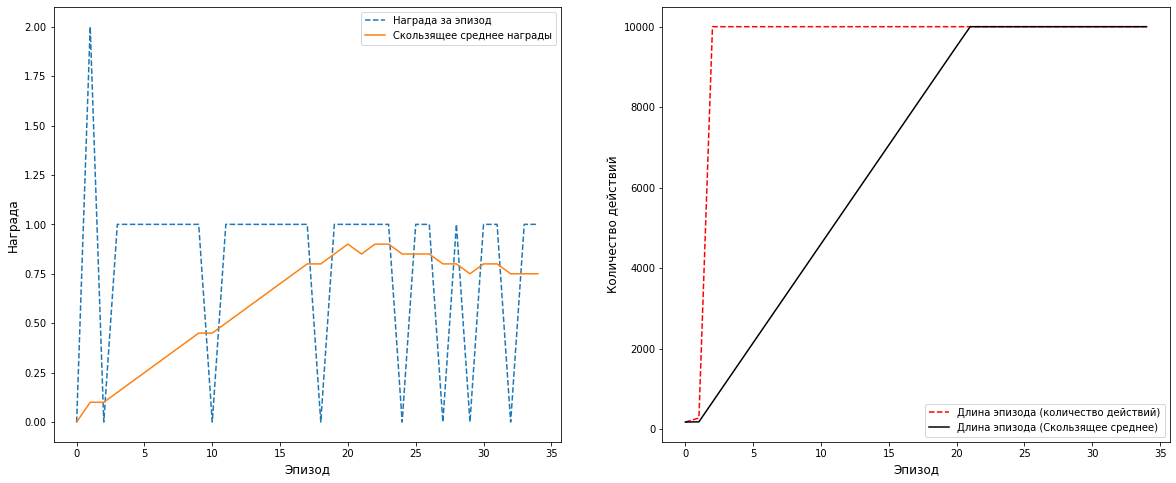

Закончен 35-й эпизод, счёт: (агент) 1, продолжительность игры: 9999 кадров.


KeyboardInterrupt: ignored

In [25]:
# Создаем среду Breakout-v0
env = gym.make('Breakout-v0')  

while episode_number < 100:

  # Список состояний одного эпизода (для обучения алгоритма)  
  episode_states = [] 

  # Список всех действий за эпизод (для обучения алгоритма)        
  episode_actions = [] 

  # Список всех наград за эпизод (для обучения алгоритма)       
  episode_rewards = []        
  
  # Запускаем среду (это действие возвращает начальное состояние)
  new_frame = env.reset()   

  # Инициализируем предыдущий кадр как текущий кадр       
  old_frame = new_frame            
  
  # Конкатенируем два кадра вместе, чтобы создать состояние
  state = stack_frames(new_frame, old_frame) 
  
  # done — переменная говорит, если игровой эпизод завершен. Инициализируется со значением False
  done = False    

  new_frame, reward, done, misc = env.step(action_space[1])  

  # Пока игровой эпизод не завершен
  while not done:       

    # Выбираем новое действие по текущему состоянию среды   
    action_index = choose_action(state)  

    # Подаем действие в среду, получаем новый кадр, награду, и узнаем, если игра окончена                                   
    new_frame, reward, done, misc = env.step(action_space[action_index])    
    
    # Добавляем состояние (с которым предсказывали действие) в массив состояний за эпизод
    episode_states.append(state)  

    # Добавляем действие в массив действий за эпизод                   
    episode_actions.append(action_index)  

    # Добавляем полученную награду в массив наград за эпизод           
    episode_rewards.append(reward)  

    # Создаем новое состояния, используя новый кадр (это нужно делать после добавления состояния в массив)                 
    state = stack_frames(new_frame, old_frame)       
    
    # Устанавливаем старый кадр как новый кадр (таким образом запоминаем старый кадр)
    old_frame = new_frame            
  
  # Увеличиваем счетчик (который отвечает за номер эпизода) на 1.
  episode_number += 1

  # Длина эпизода (количество кадров в эпизоде) равна количеству состояний за эпизод                     
  episode_timesteps = len(episode_states) 
  
  # Переводим данные в NumPy-массивы
  episode_states, episode_actions, episode_rewards = np.array(episode_states), np.array(episode_actions), np.array(episode_rewards) 
  
  # Считаем количество положительных наград (равно количеству голов, который забил агент)
  points_won = episode_rewards[episode_rewards > 0].size   
  
  # Считаем количество отрицательных наград (равно количеству голов, который пропустил агент)
  points_lost = episode_rewards[episode_rewards < 0].size  

  # Обучаем модель, используя состояния в эпизоде, соответствующие действия и награды
  train_model(episode_states, episode_actions, episode_rewards) 
  
  # Очки за эпизод = количество забитых голов — количество пропущенных голов
  episode_score = points_won - points_lost   

  # Добавляем количество очков в список (используется в качестве метрики)      
  all_scores.append(episode_score)     

  # Добавляем длину эпизода в список (используется в качестве метрики)            
  all_episode_durations.append(episode_timesteps)  
  
  # Отображаем метрики на графике
  show_scores(all_scores, all_episode_durations)   
  
  # Сохраняем прогресс раз в 10 эпизодов
  if episode_number % 10 == 0:    

    # Сохраняем веса модели
    model.save_weights('/content/REINFORCE.h5')   
    
    # Открываем файл, используя функцию из pickle
    with open('/content/scores.txt', 'wb') as f:  
      
      # Записываем метрики (очки за эпизоды, длины эпизодов, и номер эпизода) в файл
      pickle.dump([all_scores, all_episode_durations, episode_number], f)    

  # Дополнительно выводим статистику за эпизод через print
  print(f"Закончен {episode_number}-й эпизод, счёт: (агент) {points_won}, продолжительность игры: {episode_timesteps} кадров.")

К сожалению, тут мне пришлось остановить обучение. Алгоритм обучался почти 5 часов на GPU, но, как можно заметить по графику, практически ничему за это время не обучился, даже запускать мяч и просто двигаться по полю. В процессе подготовки данного задания мною были опробованы различные архитектуры моделей, с разным количеством нейронов, однако, судя по всему, алгоритму нужно гораздо больше эпох, чтобы освоиться в игре, возможно, это не часы, а дни, а, может, и недели обучения. Прошу меня поправить, если я не права.

In [27]:
def generate_episode(model):
    states_list = []                   
    action_list=[]               
    rewards_list=[]                    
    network_output_list=[]            
    env=gym.make("Breakout-v0")         
    observation = env.reset()
    observation, reward, done, info = env.step(1)       
    new_observation = observation      
    done = False 
    lifes = int(info['ale.lives'])

    
    while done == False:
        processed_network_input = preprocessing_frames(new_frame=new_observation, last_frame=observation)
        states_list.append(processed_network_input) 

        T = 0.9
        de_output = model.predict(processed_network_input[None, ...], batch_size=1)[0]
        probability = np.array(softmax(de_output/T))
        actual_action = np.random.choice(a=[0,1,2,3], size=1, p=probability)
        network_output_list.append(probability)


        if actual_action == 3:  #e c,thf
            action_list.append(1)
        elif actual_action == 2:   
            action_list.append(0.6)
        elif actual_action == 1:                      
            action_list.append(0.3)
        else:
            action_list.append(0)

        lifes = int(info['ale.lives'])
        observation = new_observation
        new_observation, reward, done, info = env.step(actual_action)

        if lifes - info['ale.lives']==1:
            reward = -1

        rewards_list.append(reward)  

        if done:
            break 

    env.close()
    return states_list, action_list, rewards_list, network_output_list

## Тестирование работы агента

In [28]:
#Создадим функцию для выбора действия при тесте. Поскольку алгоритм уже не обучается, ему не нужно разведывать среду.

# В связи с этим есть смысл в создании альтернативной функции для выбора действия. Вместо предсказывания действий рандомным образом, используя вероятности, алгоритм предскажет действия напрямую. 
# Так политика агента станет детерминированной.

def choose_test_action(state):    
    
  ''' Функция выбора действия при тесте. 

      Аргументы: 
      state - состояние
      
  '''
  # Делаем предсказание
  probs = model.predict(state.reshape(1, 80, 80, 2))  
  
  # Вместо выбора действия рандомно, выбираем действие с максимальной вероятностью
  action_index = np.argmax(probs.flatten())           
  
  # Возвращаем индекс детерминированно выбранного действия (в игровом цикле мы будем обращаться к самому действию через этот индекс)
  return action_index   

## Создание видео с игрой агента

In [29]:
# Для создания видео мы сначала создадим массив (список), куда будем поочередно добавлять кадры из игрового эпизода. 
# Затем, с помощью библиотеки moviepy, превратим массив из кадров — в видео.
# Список для записи кадров из игр
video_frames = []   

# Создаем среду Breakout-v0
env = gym.make('Breakout-v0')  

# Запускаем среду (это действие возвращает начальное состояние)  
new_frame = env.reset() 

# Инициализируем предыдущий кадр как текущий кадр
old_frame = new_frame      

# Конкатенируем два кадра вместе, чтобы создать состояние
state = stack_frames(new_frame, old_frame) 

# Done — переменная говорит, если игровой эпизод завершен. Инициализируется с значением False
done = False   

# Пока игровой эпизод не завершен
while not done:     

  # Выбираем новое действие по текущему состоянию среды детерминированным образом
  action_index = choose_test_action(state)                                   
  
  # Подаем действие в среду, получаем новый кадр (награда уже не нужна)
  new_frame, reward, done, misc = env.step(action_space[action_index])      
  
  # Добавляем новый кадр в массив кадров
  video_frames.append(new_frame)                     
  
  # Склеиваем новый и старый кадры вместе, чтобы создать новое состояние для подачи в нейросеть
  state = stack_frames(new_frame, old_frame)         
  
  # Устанавливаем старый кадр как новый кадр (таким образом запоминаем старый кадр)
  old_frame = new_frame         

In [30]:
# Создаем объект для воспроизведения видео
out = cv2.VideoWriter('/content/episode.avi',          # путь к файлу видео
                      cv2.VideoWriter_fourcc(*'DIVX'), # формат видео
                      30,                              # кадры в секунду: чем больше, тем быстрее проигрывается
                      (160, 210))                      # размер изображений
                       
# В цикле добавляем каждый кадр в видео (делаем предобработку кадра — меняем каналы с RGB в BGR, поскольку cv2 воспринимает каналы как BGR)
for i in range(len(video_frames)):   
  out.write(cv2.cvtColor(video_frames[i], cv2.COLOR_RGB2BGR))

# Закрываем объект для создания видео
out.release()   

In [31]:
# Указываем путь к видео
path="/content/episode.avi" 

# Извлекаем видео из заданного пути (куда мы ранее записали видео через cv2)
clip=VideoFileClip(path) 

# Отображаем видео в Colab
clip.ipython_display(width=320, maxduration = 1000) 

100%|██████████| 10000/10000 [00:06<00:00, 1443.91it/s]


## Выводы

В процессе выполнения данного задания был  обучен алгоритм REINFORCE на среде breakout-v0 из библиотеки gym. Скачаны нужные файлы для библиотеки gym, созданы необходимые рабочие функции, опробованы различные архитектуры модели, обучена модель на 35 эпизодах, создано и воспроизведено видео с игрой агента, обученного на нашей модели. К сожалению, за время обучния агент не научился даже запускать мяч, а также не понял, что необходимо двигаться по полю. Предполагаю, что 35 эпизодов недостаточно для того, чтобы агент чему-то научился. 